## Credit Card Approval Prediction

### ABOUT DATA PROBLEM :: 


Credit scoring is a widely used risk management technique in the financial sector. It makes use of personal information and data provided by credit card applicants to estimate future bankruptcies and credit card loans. The bank has the authority to determine whether or not to provide the applicant a credit card. Credit scores can estimate the level of risk objectively.

A machine learning model is required to predict if an application is a 'good' or 'bad' user in this dataset. However, there is no definition of 'good' or 'bad'. Additionally, the unbalanced data problem is a significant issue in this project.

There are 2 datasets will be used in this notebook:

**Application record (contains general information about applicant, such as applicant gender, DOB, education type, assets that applicant had, etc.)**

**Credit record (contains applicant's loan payment records)**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

### Reading & Analyzing Data

In [21]:
df_credit = pd.read_csv('credit_record.csv')  
df_application = pd.read_csv('application_record.csv')

credit_record.csv		
Feature name	Explanation	 Remarks
- ID	: Client number	
- Record month	: The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
- STATUS :	Status	
        - 0: 1-29 days past due 
        - 1: 30-59 days past due 
        - 2: 60-89 days overdue 
        - 3: 90-119 days overdue - 
        - 4: 120-149 days overdue 
        - 5: Overdue or bad debts, write-offs for more than 150 days 
        - C: paid off that month 
        - X: No loan for the month

In [3]:
def basic_info(df, name=''):
    print(f'Shape of the {name} data is : {df.shape}')
    print('--'*50)
    print(f'Datatype of the {name} dataset are : {df.dtypes}')
    print('--'*50)
    cat_col = [col for col in df.select_dtypes(include='object')]
    print(f'Categorical Columns of the {name} data is {cat_col}')
    print('--'*50)
    num_col = [col for col in df.select_dtypes(exclude='object')]
    print(f'Categorical Columns of the {name} data is {num_col}')
    print('--'*50)    

In [4]:
basic_info(df_credit, 'CREDIT')
print()
print('**'*50)
print('**'*50)
print()
basic_info(df_application, 'APPLICATION')

Shape of the CREDIT data is : (1048575, 3)
----------------------------------------------------------------------------------------------------
Datatype of the CREDIT dataset are : ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object
----------------------------------------------------------------------------------------------------
Categorical Columns of the CREDIT data is ['STATUS']
----------------------------------------------------------------------------------------------------
Categorical Columns of the CREDIT data is ['ID', 'MONTHS_BALANCE']
----------------------------------------------------------------------------------------------------

****************************************************************************************************
****************************************************************************************************

Shape of the APPLICATION data is : (438557, 18)
-------------------------------------------------------

In [5]:
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [22]:
credit_group = df_credit.groupby('ID')['MONTHS_BALANCE'].min()

In [23]:
# Creating a month on book column which tells us the no. of month it has been since the account opened 
# and maps the months balance in a manner that is understandable easily.

df_credit['open_month'] =  df_credit['ID'].apply(lambda x: credit_group.loc[x])
df_credit['month_on_book'] = df_credit['MONTHS_BALANCE'] - df_credit['open_month']
# df_credit.drop(['MONTHS_BALANCE', 'open_month'], axis=1, inplace=True)
df_credit.head()

,ID,MONTHS_BALANCE,STATUS,open_month,month_on_book
0,5001711,0,X,-3,3
1,5001711,-1,0,-3,2
2,5001711,-2,0,-3,1
3,5001711,-3,0,-3,0
4,5001712,0,C,-18,18


Conisdering account who has paid due on 0th status which means past 1-29 days. I wanted to check how the 0th status number compare with the other status values who has paid due 

In [8]:
perc_of_oth = len(df_credit[df_credit['STATUS'] == '0']) / (df_credit.shape[0] - len(df_credit[(df_credit['STATUS'] != 'C') & (df_credit['STATUS'] != 'X')])) * 100
perc_of_oth

58.8274132797757

As expected in dataset , 58% accounts have entries of paying dues within 1-29 . So , we'll not consider them as a BAD application

In [24]:
# changing status as 0 and 1 , 0 - GOOD (PAID FULLY) ,  1 - BAD (DIDN'T PAID)

df_credit.STATUS = df_credit.STATUS.map({'C':0, 'X':0, '0':0, '1':1, '2':1, '3':1, '4':1, '5':1,})
df_credit.STATUS.value_counts()

0    1034381
1      14194
Name: STATUS, dtype: int64

In [10]:
# dropping duplicates if any
df_credit.drop_duplicates(inplace=True)

In [29]:
df_credit.head()

,ID,MONTHS_BALANCE,STATUS,open_month,month_on_book
0,5001711,0,0,-3,3
1,5001711,-1,0,-3,2
2,5001711,-2,0,-3,1
3,5001711,-3,0,-3,0
4,5001712,0,0,-18,18


In [67]:
# count how many users in every month the account was opened

temp_df = df_credit[['ID', 'open_month']] 
temp_df = denominator.drop_duplicates()
temp_df = temp_df.groupby(['open_month']).agg({'ID': ['count']})
temp_df.reset_index(inplace = True)
temp_df.columns = ['open_month','sta_sum']

temp_df.head()

,open_month,sta_sum
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470


In [68]:
new = pd.merge(df_credit, temp_df, on='open_month', how='left')
new.head(10)

,ID,MONTHS_BALANCE,STATUS,open_month,month_on_book,sta_sum
0,5001711,0,0,-3,3,919
1,5001711,-1,0,-3,2,919
2,5001711,-2,0,-3,1,919
3,5001711,-3,0,-3,0,919
4,5001712,0,0,-18,18,911
5,5001712,-1,0,-18,17,911
6,5001712,-2,0,-18,16,911
7,5001712,-3,0,-18,15,911
8,5001712,-4,0,-18,14,911
9,5001712,-5,0,-18,13,911


In [12]:
month_list = [i for i in range(0,61,6)]

grp = df_credit.groupby(['ID'])['STATUS', 'month_on_book']

df_new = pd.DataFrame()

In [70]:
new[new['open_month']==-6]

,ID,MONTHS_BALANCE,STATUS,open_month,month_on_book,sta_sum
370,5001729,0,0,-6,6,1025
371,5001729,-1,0,-6,5,1025
372,5001729,-2,0,-6,4,1025
373,5001729,-3,0,-6,3,1025
374,5001729,-4,0,-6,2,1025
...,...,...,...,...,...,...
1046971,5150331,-2,0,-6,4,1025
1046972,5150331,-3,0,-6,3,1025
1046973,5150331,-4,0,-6,2,1025
1046974,5150331,-5,0,-6,1,1025


In [75]:
df_credit[df_credit['month_on_book'] == 6]

,ID,MONTHS_BALANCE,STATUS,open_month,month_on_book
16,5001712,-12,0,-18,6
38,5001713,-15,0,-21,6
53,5001714,-8,0,-14,6
113,5001715,-53,0,-59,6
135,5001717,-15,0,-21,6
...,...,...,...,...,...
1048487,5150481,-36,0,-42,6
1048505,5150482,-22,0,-28,6
1048523,5150483,-11,0,-17,6
1048536,5150484,-6,0,-12,6


In [69]:
for i in month_list:
    sum_bad, grp_count = 0, 0
    for index, g in grp:
        if i in list(g['month_on_book']):
            grp_count += 1
            if 1 in list(g[g['month_on_book'] <= i]['STATUS']):
                sum_bad += 1
                
    print(i, sum_bad, grp_count)
                
    df_new[i] = [round((sum_bad / grp_count)*100, 2)]

0 14 45985
6 2850 39330
12 3382 30918
18 2923 23935
24 2403 18296
30 1926 13641
36 1486 9820
42 1015 6401
48 621 3836
54 304 1776
60 42 222


In [20]:
# df_new = pd.DataFrame()

# df_new[0] = [50]
# df_new[23] = [34]
df_new.head()

,0,23,6,12,18,24,30,36,42,48,54,60
0,0.03,34,7.25,10.94,12.21,13.13,14.12,15.13,15.86,16.19,17.12,18.92


### Concatenating Datasets

In [11]:
print(f'No. of IDs in application_record = {len(df_application.ID)}')
print(f'No. of IDs in credit_record = {len(df_credit.ID)}')

No. of IDs in application_record = 438557
No. of IDs in credit_record = 1048575


In [12]:
df_final = pd.merge(df_application, df_credit, on='ID', how='inner')
df_final.shape

(777715, 20)

In [13]:
df_final.drop(['ID'], axis=1, inplace=True)
df_final.rename(columns={'STATUS':'TARGET'}, inplace=True)

In [14]:
df_final.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET,month_on_book
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,15
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,14
2,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,13
3,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,12
4,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,11


In [15]:
df_final.drop(['month_on_book'], axis=1, inplace=True)
print(df_final.shape)
df_final.drop_duplicates(inplace=True)
print(df_final.shape)

(777715, 18)
(12132, 18)


In [98]:
df_final.shape

(12132, 18)

In [99]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12132 entries, 0 to 777711
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          12132 non-null  object 
 1   FLAG_OWN_CAR         12132 non-null  object 
 2   FLAG_OWN_REALTY      12132 non-null  object 
 3   CNT_CHILDREN         12132 non-null  int64  
 4   AMT_INCOME_TOTAL     12132 non-null  float64
 5   NAME_INCOME_TYPE     12132 non-null  object 
 6   NAME_EDUCATION_TYPE  12132 non-null  object 
 7   NAME_FAMILY_STATUS   12132 non-null  object 
 8   NAME_HOUSING_TYPE    12132 non-null  object 
 9   DAYS_BIRTH           12132 non-null  int64  
 10  DAYS_EMPLOYED        12132 non-null  int64  
 11  FLAG_MOBIL           12132 non-null  int64  
 12  FLAG_WORK_PHONE      12132 non-null  int64  
 13  FLAG_PHONE           12132 non-null  int64  
 14  FLAG_EMAIL           12132 non-null  int64  
 15  OCCUPATION_TYPE      12132 non-null

In [100]:
num_col = df_final.select_dtypes(exclude='object').columns
cat_col = df_final.select_dtypes(include='object').columns

### Handling Null Values

In [101]:
df_final['OCCUPATION_TYPE'].fillna('NOT EMPLOYED', inplace=True)
df_final['OCCUPATION_TYPE'].value_counts()

NOT EMPLOYED             3703
Laborers                 2142
Sales staff              1186
Core staff               1122
Managers                  987
Drivers                   774
High skill tech staff     457
Accountants               376
Medicine staff            373
Cooking staff             241
Security staff            240
Cleaning staff            182
Private service staff     101
Low-skill Laborers         70
Secretaries                56
Waiters/barmen staff       49
HR staff                   32
IT staff                   21
Realty agents              20
Name: OCCUPATION_TYPE, dtype: int64

# Uni-Variate Analysis

## For cat_col

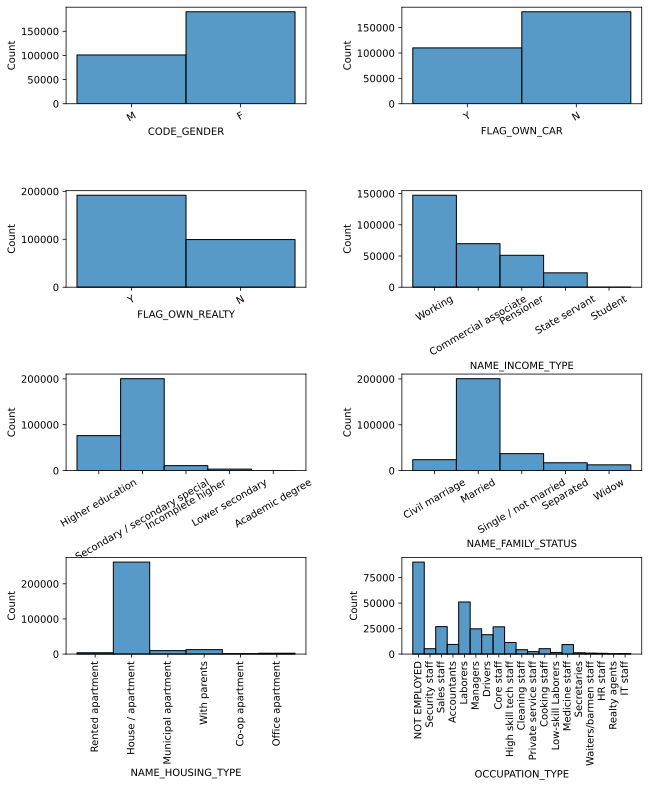

In [19]:
plt.figure(figsize=(10,10))
for ind, col in enumerate(cat_col):
    plt.subplot(4,2,ind+1)
    plt.subplots_adjust(left=0.1,
                    bottom=0.001,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.9)
    if ind < 6:
        plt.xticks(rotation=30)
    else:      
        plt.xticks(rotation=90)
    sns.histplot(data=df_final, x=col)

The Data is highly imbalanced as we can see from the graph above, Still some of the keypoints form the graph are :
- Most of the applicants are married and owns a house/ appartment which kind of makes sense. Considering people marries generally when they're quite settled.
- In occupation type, NOT EMPLOYED has the highest occurence , it was null in the start . I think I'd have to do some more feature engineering to decide whether it can be filled with some thing else.

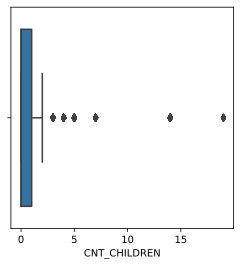

In [20]:
plt.figure(figsize=(4,4))
sns.boxplot(x='CNT_CHILDREN', data=df_final)
# plt.boxplot(df_final['CNT_CHILDREN'])
plt.show()

In [62]:
num_col

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'TARGET', 'month_on_book'],
      dtype='object')

In [103]:
for col in num_col:
    q_hi = df_final[col].quantile(0.999)
    q_low = df_final[col].quantile(0.001)
    
    print(f'q_hi : {q_hi} and q_low {q_low} for {col}')
    print(f'max : {df_final[col].max()} and min : {df_final[col].min()}')
    print()

q_hi : 4.0 and q_low 0.0 for CNT_CHILDREN
max : 19 and min : 0

q_hi : 900000.0 and q_low 33300.0 for AMT_INCOME_TOTAL
max : 1575000.0 and min : 27000.0

q_hi : -8057.440999999993 and q_low -24841.428 for DAYS_BIRTH
max : -7489 and min : -25152

q_hi : 365243.0 and q_low -14465.14 for DAYS_EMPLOYED
max : 365243 and min : -15713

q_hi : 1.0 and q_low 1.0 for FLAG_MOBIL
max : 1 and min : 1

q_hi : 1.0 and q_low 0.0 for FLAG_WORK_PHONE
max : 1 and min : 0

q_hi : 1.0 and q_low 0.0 for FLAG_PHONE
max : 1 and min : 0

q_hi : 1.0 and q_low 0.0 for FLAG_EMAIL
max : 1 and min : 0

q_hi : 6.0 and q_low 1.0 for CNT_FAM_MEMBERS
max : 20.0 and min : 1.0

q_hi : 1.0 and q_low 0.0 for TARGET
max : 1 and min : 0



In [102]:
df_final.shape

(12132, 18)

There are outliers in 3 columns.

- CNT_CHILDREN
- AMT_INCOME_TOTAL
- CNT_FAM_MEMBERS


- -  We need to remove these outliers to make sure they do not affect our model results.
- - We will now remove these outliers.

In [107]:
# Removing Outlier

cols = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']

print('Shape of dataset before removing outlier is : ', df_final.shape)

for col in cols:
    q_hi = df_final[col].quantile(0.999)
    q_low = df_final[col].quantile(0.001)
    df_final = df_final[(df_final[col]>=q_low) & (df_final[col]<=q_hi)]
    
print('Shape of dataset after removing outlier is : ', df_final.shape)


Shape of dataset before removing outlier is :  (11917, 18)
Shape of dataset after removing outlier is :  (11895, 18)


In [108]:
df_final.TARGET.value_counts()

0    9541
1    2354
Name: TARGET, dtype: int64

Around 24% of the data we have for the application which was rejected for credit card. So, it's a very highly imbalanced dataset.

First we'll develop a baseline model and then we'll solve the imbalance problem and again build a model to see if it changes anything

## Feature Engineering 

In [109]:
for col in cat_col:
    print(col, ' has ', df_final[col].nunique(), ' unique values')

CODE_GENDER  has  2  unique values
FLAG_OWN_CAR  has  2  unique values
FLAG_OWN_REALTY  has  2  unique values
NAME_INCOME_TYPE  has  5  unique values
NAME_EDUCATION_TYPE  has  5  unique values
NAME_FAMILY_STATUS  has  5  unique values
NAME_HOUSING_TYPE  has  6  unique values
OCCUPATION_TYPE  has  19  unique values


In [110]:
df_final.reset_index(inplace=True, drop=True)
df_final.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NOT EMPLOYED,2.0,0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NOT EMPLOYED,2.0,1
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NOT EMPLOYED,1.0,0


In [111]:
label = df_final['TARGET']
df_final.drop(['TARGET'], axis=1, inplace=True)
features = df_final

### Label Encoding

In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in features.columns:
    if features[col].dtype == 'object':
#         features[col] = le.fit_transform(features[col])
        print(col)

CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE


### Feature Scaling

In [29]:
from sklearn.preprocessing import MinMaxScaler

ms = MinMaxScaler()

In [30]:
for col in num_col:
    if col != 'TARGET':
        features[col] = le.fit_transform(features[col])

In [116]:
features.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NOT EMPLOYED,2.0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NOT EMPLOYED,2.0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NOT EMPLOYED,1.0


# Splitting the dataset

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=0)

### Some helpful functions

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score


# Function to show different evaluation parameter
def results_viewer(actual, predicted):
    acc = accuracy_score(actual ,predicted)
    confusion_mat = confusion_matrix(actual ,predicted)
    pre_score = precision_score(actual ,predicted)
    recall = recall_score(actual ,predicted)
    f1 = f1_score(actual ,predicted)
    specificitactual  = confusion_mat[0,0] / (confusion_mat[0,0] + confusion_mat[0,1])

    print(f'Accuracy Score = {acc}\nPrecision Score = {pre_score}\nRecall Score = {recall}\nF1 Score = {f1}\nSpecificity Test = {specificitactual }\n\nConfusion Matrix = \n{confusion_mat}')
    
# Function to plot confusion matrix  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        
    print('Confusion Matrix')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Model Building on Imbalanced dataset

In [46]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

In [38]:
from sklearn.model_selection import KFold,StratifiedKFold

kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=0)

### Decision Tree Classifier

Accuracy Score = 0.875744733124501
Precision Score = 0.16907577748576436
Recall Score = 0.75390625
F1 Score = 0.27620751341681576
Specificity Test = 0.8797006785465153

Confusion Matrix = 
[[13872  1897]
 [  126   386]]
Confusion Matrix
[[0.87970068 0.12029932]
 [0.24609375 0.75390625]]


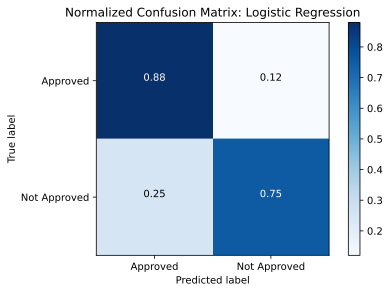

In [42]:
DTclassifier = DecisionTreeClassifier(class_weight='balanced', 
                                    max_depth=35, 
                                    splitter='best', 
                                    random_state=42,
                                    min_samples_split=38)
DTclassifier.fit(X_train, y_train)

y_pred = DTclassifier.predict(X_test)
y_pred_train= DTclassifier.predict(X_train)

results_viewer(y_test, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

### Logistic Regression

Accuracy Score = 0.5726306737915361
Precision Score = 0.04745857905082842
Recall Score = 0.66015625
F1 Score = 0.08855121823421534
Specificity Test = 0.569788826177944

Confusion Matrix = 
[[8985 6784]
 [ 174  338]]
Confusion Matrix
[[0.56978883 0.43021117]
 [0.33984375 0.66015625]]


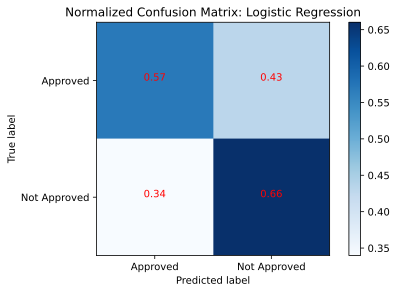

In [49]:
lr = LogisticRegression(C=0.7,
                        class_weight='balanced',
                        n_jobs=-1
                       )

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_pred_train= lr.predict(X_train)

results_viewer(y_test, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')
                        

# Balancing Data

### Using Smote ( synthetic minority oversampling technique )

In [41]:
X_train, X_test, y_train, y_test

(       CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
 44906            1             1                1             1   
 51072            1             0                1             1   
 62476            0             0                1             1   
 76228            1             0                0             1   
 24224            0             0                1             0   
 ...            ...           ...              ...           ...   
 21243            1             0                0             0   
 45891            0             0                1             1   
 42613            0             0                0             0   
 43567            1             1                1             0   
 68268            1             0                1             0   
 
        AMT_INCOME_TOTAL  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
 44906                59                 0                    4   
 51072                49                 4      

In [43]:
# import library
from collections import Counter
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 63135, 1: 1985})
Resample dataset shape Counter({0: 63135, 1: 63135})


In [51]:
X_trainB, X_testB, y_trainB, y_testB = train_test_split(x_smote, y_smote, test_size=0.2, random_state=0)

In [56]:
from sklearn.model_selection import GridSearchCV

### Logistic Regression

In [60]:
lr = LogisticRegression()

params = {  'solver':['newton-cg', 'lbfgs', 'liblinear'],
            'penalty':['l2'],
            'C':[100, 10, 1.0, 0.1, 0.01]
         }

logistic_grid_search = GridSearchCV(lr, param_grid=params, cv=3, n_jobs=-1)

logistic_grid_search.fit(X_trainB, y_trainB)

# print best estimator parameters found during the grid search
print(logistic_grid_search.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


creating the logistic regreassion model with the best parameters

Accuracy Score = 0.6511627906976745
Precision Score = 0.6424731182795699
Recall Score = 0.6920558982752109
F1 Score = 0.6663434147524092
Specificity Test = 0.6097218678234243

Confusion Matrix = 
[[ 9558  6118]
 [ 4892 10994]]
Confusion Matrix
[[0.60972187 0.39027813]
 [0.3079441  0.6920559 ]]


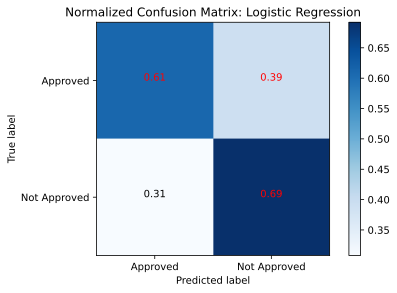

In [63]:
best_lr = LogisticRegression(C=0.1, penalty='l2', solver='liblinear')
best_lr.fit(X_trainB, y_trainB)

y_pred = best_lr.predict(X_testB)
y_pred_train= best_lr.predict(X_trainB)

results_viewer(y_testB, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_testB, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

Accuracy Score = 0.6140286223204963
Precision Score = 0.047080979284369114
Recall Score = 0.5859375
F1 Score = 0.08715862870424171
Specificity Test = 0.6149407064493627

Confusion Matrix = 
[[9697 6072]
 [ 212  300]]
Confusion Matrix
[[0.61494071 0.38505929]
 [0.4140625  0.5859375 ]]


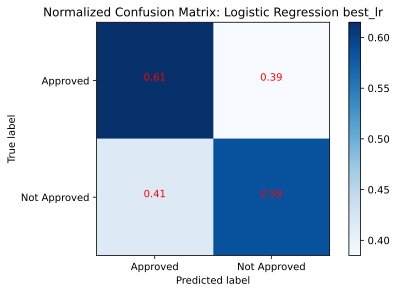

In [64]:
y_pred = best_lr.predict(X_test)
results_viewer(y_test, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression best_lr')

I don't think logistic regression can be used to solve this problem. Reason could be the data is not linear as many features were categorical and numericalfeature also didn't follow linear relationship

### Decision Tree Classifier

Accuracy Score = 0.943793169000697
Precision Score = 0.9320352681851579
Recall Score = 0.9582021906080825
F1 Score = 0.9449376125147433
Specificity Test = 0.9291911201837203

Confusion Matrix = 
[[14566  1110]
 [  664 15222]]
Confusion Matrix
[[0.92919112 0.07080888]
 [0.04179781 0.95820219]]


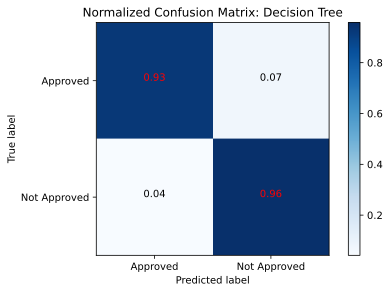

In [54]:
DTclassifier = DecisionTreeClassifier(class_weight='balanced', 
                                    max_depth=35, 
                                    splitter='best', 
                                    random_state=42,
                                    min_samples_split=38)
DTclassifier.fit(X_trainB, y_trainB)

y_pred = DTclassifier.predict(X_testB)
y_pred_train= DTclassifier.predict(X_train)

results_viewer(y_testB, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_testB, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Decision Tree')

Accuracy Score = 0.9356304895276703
Precision Score = 0.30551523947750364
Recall Score = 0.822265625
F1 Score = 0.44550264550264557
Specificity Test = 0.9393113069947365

Confusion Matrix = 
[[14812   957]
 [   91   421]]
Confusion Matrix
[[0.93931131 0.06068869]
 [0.17773438 0.82226562]]


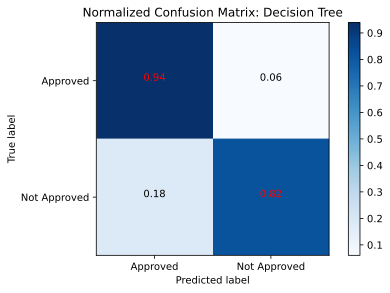

In [55]:
y_pred = DTclassifier.predict(X_test)
results_viewer(y_test, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Decision Tree')

Accuracy Score = 0.9385787113813647
Precision Score = 0.2744916820702403
Recall Score = 0.580078125
F1 Score = 0.37264742785445415
Specificity Test = 0.9502187836895174

Confusion Matrix = 
[[14984   785]
 [  215   297]]
Confusion Matrix
[[0.95021878 0.04978122]
 [0.41992188 0.58007812]]


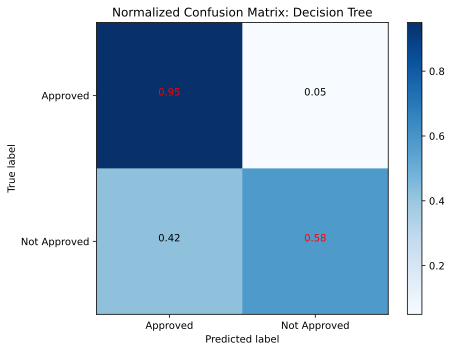

In [48]:
DTclassifier = DecisionTreeClassifier(class_weight='balanced', 
                                    max_depth=35, 
                                    splitter='best', 
                                    random_state=42,
                                    min_samples_split=38)
DTclassifier.fit(x_smote, y_smote)

y_pred = DTclassifier.predict(X_test)
y_pred_train= DTclassifier.predict(x_smote)

results_viewer(y_test, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Decision Tree')

Accuracy Score = 0.9385787113813647
Precision Score = 0.2744916820702403
Recall Score = 0.580078125
F1 Score = 0.37264742785445415
Specificity Test = 0.9502187836895174

Confusion Matrix = 
[[14984   785]
 [  215   297]]
Confusion Matrix
[[0.95021878 0.04978122]
 [0.41992188 0.58007812]]


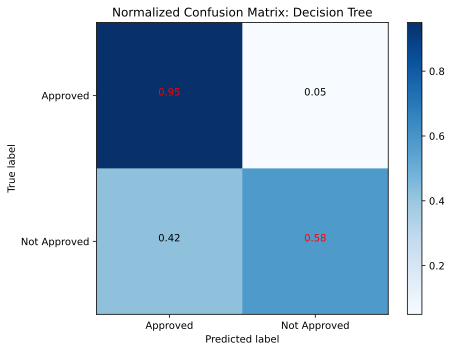

In [49]:
y_pred = DTclassifier.predict(X_test)
results_viewer(y_test, y_pred)


class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Decision Tree')

### KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)

KNN_grid_search = GridSearchCV(KNN, param_grid=grid, cv=3, n_jobs=-1)

KNN_grid_search.fit(X_trainB, y_trainB)

# print best estimator parameters found during the grid search
print(KNN_grid_search.best_params_)

{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


Accuracy Score = 0.9523477599645143
Precision Score = 0.9493813273340832
Recall Score = 0.9563137353644718
F1 Score = 0.9528349222277973
Specificity Test = 0.9483286552692013

Confusion Matrix = 
[[14866   810]
 [  694 15192]]
Confusion Matrix
[[0.94832866 0.05167134]
 [0.04368626 0.95631374]]


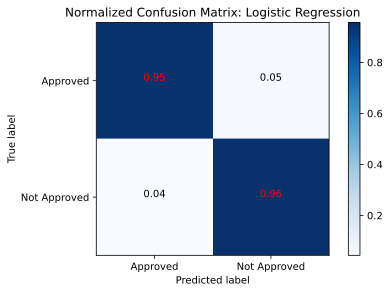

In [69]:
best_knn = KNeighborsClassifier(metric='euclidean', n_neighbors= 1, weights='uniform')
best_knn.fit(X_trainB, y_trainB)

y_pred = best_knn.predict(X_testB)
y_pred_train= best_knn.predict(X_trainB)

results_viewer(y_testB, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_testB, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: Logistic Regression')

In [ ]:
y_pred = best_knn.predict(X_test)
results_viewer(y_test, y_pred)

class_names = ['Approved','Not Approved']    
plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: KNN best_knn')

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score


# xgb = XGBClassifier()

# # create Grid
# param_grid = {'n_estimators': [100, 150, 200],
#               'learning_rate': [0.01, 0.05, 0.1], 
#               'max_depth': [3, 4, 5, 6, 7],
#               'colsample_bytree': [0.6, 0.7, 1],
#               'gamma': [0.0, 0.1, 0.2]}

# # instantiate the tuned random forest
# booster_grid_search = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1)

# # train the tuned random forest
# booster_grid_search.fit(X_train, y_train)

# # print best estimator parameters found during the grid search
# print(booster_grid_search.best_params_)

# # instantiate xgboost with best parameters
# xgb = XGBClassifier(colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, 
#                            max_depth=7, n_estimators=200, random_state=4)

# # train
# xgb.fit(X_train, y_train)

# # predict
# y_pred = xgb.predict(X_test)